Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio# 读写图片，视频，及科学的大量的数据格式
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile#读写压缩文件
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve#six 库兼容python2 3
from six.moves import cPickle as pickle #pickle提供了一个简单的持久化功能。可以将对象以文件的形式存放在磁盘上

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline 

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [3]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1' # Change me to store data elsewhere  很有经验的做法，即把文件绝对路径存储下来，方便移植

def download_progress_hook(count, blockSize, totalSize):#hook 钩子 劫持信息的小程序
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported #声明global 为了可以在函数内部改变全局变量
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent) #当我们在 Python 中打印对象调用 print obj 时候，事实上是调用了 sys.stdout.write(obj+'\n')
                                         #print 将你需要的内容打印到了控制台，然后追加了一个换行符
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):#froce就是默认参数，变化少 可以减少函数调用参数的维度
  """Download a file if not present, and make sure it's the right size."""#确保这个文件名不存在
  dest_filename = os.path.join(data_root, filename)#链接两个路径
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)#大的用来训练
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)#小的用来测试

Found and verified /Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_large.tar.gz
Found and verified /Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labeled A through J.

In [4]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz filename后面的那个0因为这里面有两个“.” 二维tuple
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)#打开压缩文件
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()#有open就有close
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_large already present - Skipping extraction of /Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_large.tar.gz.
['/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_large/A', '/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_large/B', '/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_large/C', '/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_large/D', '/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_large/E', '/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_large/F', '/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_large/G', '/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_large/H', '/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_large/I', '/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_large/J']
/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_small already present 

---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [5]:
print(train_folders)

['/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_large/A', '/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_large/B', '/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_large/C', '/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_large/D', '/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_large/E', '/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_large/F', '/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_large/G', '/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_large/H', '/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_large/I', '/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_large/J']


In [6]:
l = ['i','l','o','v','e','u']
for label, pickle_file in enumerate(l):
    print(label,pickle_file)

0 i
1 l
2 o
3 v
4 e
5 u


In [10]:
display(Image(filename='/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_small/A/Q2Fsdmlub0hhbmQudHRm.png'))

Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [15]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)#每个字母中图片的个数
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:#遍历每一张图片
    image_file = os.path.join(folder, image)
    try:
      image_data = (imageio.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data#处理每张图片，把png图片变成了数字
      num_images = num_images + 1
    except (IOError, ValueError) as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset#只是其中的一个字母
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:#遍历每一个字母
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)#pickle.dump(obj, file[, protocol])序列化对象，并将结果数据流写入到文件对象中
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_large/A.pickle already present - Skipping pickling.
/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_large/B.pickle already present - Skipping pickling.
/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_large/C.pickle already present - Skipping pickling.
/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_large/D.pickle already present - Skipping pickling.
/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_large/E.pickle already present - Skipping pickling.
/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_large/F.pickle already present - Skipping pickling.
/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_large/G.pickle already present - Skipping pickling.
/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_large/H.pickle already present - Skipping pickling.
/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_large/I.pickle already pre

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

In [16]:
print(test_datasets)

['/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_small/A.pickle', '/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_small/B.pickle', '/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_small/C.pickle', '/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_small/D.pickle', '/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_small/E.pickle', '/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_small/F.pickle', '/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_small/G.pickle', '/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_small/H.pickle', '/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_small/I.pickle', '/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_small/J.pickle']


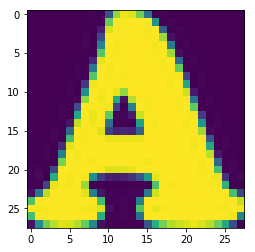

In [27]:
f=open('/Users/yuanhaoran/Documents/SUPAERO-3/deeplearning-1/notMNIST_small/A.pickle','rb')  
bb=pickle.load(f)  
f.close()  
imgplot = plt.imshow(bb[110,:,:])
#imgplot = plt.imshow(bb[110])

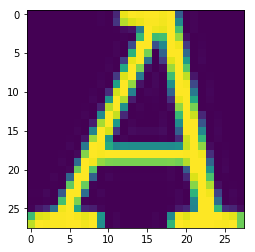

In [20]:
pickle_file = test_datasets[0]  # index 0 should be all As, 1 = all Bs, etc.
with open(pickle_file, 'rb') as f:
    letter_set = pickle.load(f)  # unpickle
    sample_idx = np.random.randint(len(letter_set))  # pick a random image index
    sample_image = letter_set[sample_idx, :, :]  # extract a 2D slice
    plt.figure()
    plt.imshow(sample_image)  # display it

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [11]:
len_folder = []
for folder_1 in train_datasets:  
    f=open(folder_1,'rb')  
    bb=pickle.load(f) 
    len_folder.append(len(bb))
f.close() 

In [12]:
max(len_folder)/min(len_folder)

1.0000567011283525

In [13]:
len_folder1 = []
for folder_1 in test_datasets:  
    f=open(folder_1,'rb')  
    bb=pickle.load(f) 
    len_folder1.append(len(bb))
f.close() 
max(len_folder1)/min(len_folder1)

1.000534188034188

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [14]:
def make_arrays(nb_rows, img_size):#精简数据集
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)#num_class 是10，十个数字
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes#每一个数字 validate dataset的大小
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files): #遍历每一个数字 list竟然可以遍历   
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)#打乱每一个图片中的一个数组，格式是Array
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]#每一个字母，只存储vsize_per_class个数组的数据
          valid_dataset[start_v:end_v, :, :] = valid_letter#然后存入valide_dataset数组中
          valid_labels[start_v:end_v] = label#label也同理，十个元素
          start_v += vsize_per_class#更新存放的位置，valide_letter数组是反复用的，valide_dataset是要做返回值的
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]#train同理
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(    #可以看出，使用了trainset来生成valide set
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)#生成test的方法和triangle相同

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [15]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])#全排列函数
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [16]:
np.random.permutation(test_labels.shape[0])# 返回值是一个数组

array([7367, 8306,  896, ..., 7927, 5660, 7382])

In [17]:
test_labels

array([3, 6, 4, ..., 6, 9, 0], dtype=int32)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

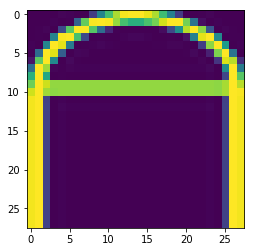

In [18]:
f=open('./notMNIST_small/A.pickle','rb')  
bb=pickle.load(f)  
f.close()  
imgplot = plt.imshow(bb[565])

Finally, let's save the data for later reuse:

In [19]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [20]:
f=open('./notMNIST.pickle','rb')  
bb=pickle.load(f)  
f.close()  
type(bb)

dict

In [21]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800506


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [21]:
#TODO

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [22]:
f=open('./notMNIST.pickle','rb')  
bb=pickle.load(f)  
f.close()

In [23]:
bb.keys()

dict_keys(['train_dataset', 'train_labels', 'valid_dataset', 'valid_labels', 'test_dataset', 'test_labels'])

In [24]:
train_label = bb.get('train_labels')
train = bb.get('train_dataset')
test = bb.get('test_dataset')
test_label = bb.get('test_labels')

In [25]:
def flatten_dataset(dataset):
    dataset_flatten = []
    for i in range(dataset.shape[0]):
        dataset_flatten.append(train[i].flatten())
    return dataset_flatten

In [26]:
trained = flatten_dataset(train)

In [27]:
tested = flatten_dataset(test)

In [28]:
lr = LogisticRegression()

In [35]:
def range_score():
    num_iter = [50,100,1000,5000]
    score = []
    for i in range(len(num_iter)):
        lr.fit(trained[0:num_iter[i]],train_label[0:num_iter[i]])
        score.append(lr.score(tested,test_label))
    plt.plot(num_iter,score)

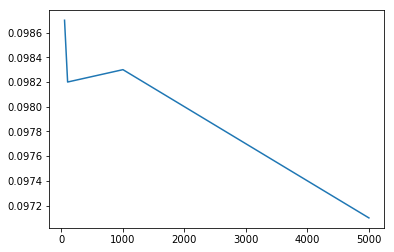

In [36]:
range_score()